# GMM method analysis and final errors for DS-IE

In [ ]:
NOTEBOOK_CONFIG = {
    "IMG_LENGTH": 0.377,
    "IMG_WIDTH": 0.143,
    "IMG_XDIM": 143,
    "IMG_YDIM": 377,
    "labels_type": "Labelsv0_detect",
    "task": "detect",
    "model_name": "YOLOv0_E12_detect",
}

In [2]:
# Sample image
n_image = 209
image_path = f"docs/Data/Images/gaussian_{n_image}.png"
label_path = f"docs/Data/{NOTEBOOK_CONFIG['labels_type']}/gaussian_{n_image}.txt"

In [4]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [5]:
import os
import pandas as pd
import numpy as np

from datetime import datetime

from matplotlib import pyplot as plt

In [6]:
from scipy.ndimage import laplace
import scipy.io

from skimage.feature import peak_local_max
from adjustText import adjust_text

In [7]:
from PIL import Image

# Load modules

In [14]:
from helpers.auxiliary_functions import (
    generate_grid,
    parameters_extract,
    checkpoint_error,
)
from helpers.aux_plotter import plot_boxes_gmm, gaussians_labelled, plot_grayscale
from helpers.gaussian_estimation import sum_gaussians, compute_mse

from pipelines.pipelines import ppl_fit_gaussians, ppl_error_estimation

    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        print(f"{func.__name__} executed in {end_time - start_time} seconds")
        return result



# Data from CNR

## Load
- Real size of the tile is roughly equal to 2 pixel / mm

In [15]:
# Load 400 gaussians
mat = scipy.io.loadmat("Data/db_80beam.mat")
print(mat.keys())

dict_keys(['__header__', '__version__', '__globals__', 'F_data', 'Fit_flux', 'beta'])


In [16]:
# Generate GRID
x, y = generate_grid(
    (0, NOTEBOOK_CONFIG["IMG_WIDTH"]),
    (0, NOTEBOOK_CONFIG["IMG_LENGTH"]),
    NOTEBOOK_CONFIG["IMG_XDIM"],
    NOTEBOOK_CONFIG["IMG_YDIM"],
)

## Box of the gaussians - using dispersion_x and dispersion_y (from true parameters)

In [17]:
# Load data
# Image - z intensities
image = [x, y, mat["F_data"][:, :, n_image]]

# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(
    mat["Fit_flux"], n_image
)

In [ ]:
# Structure covariances
covariances = [
    np.diag(cov)
    for cov in zip((dispersion_x / np.sqrt(2)) ** 2, (dispersion_y / np.sqrt(2)) ** 2)
]

Number of indentifiable Gaussians (center in the image): 79


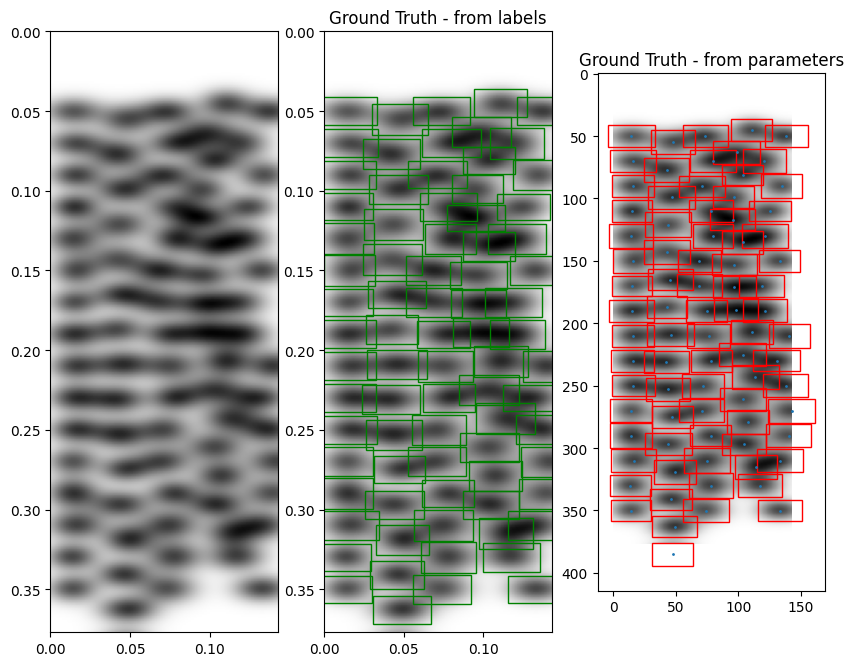

In [ ]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize=(10, 10))

# Display the image
axs[2].imshow(im)
plot_boxes_gmm(means=list(zip(xs, ys)), covariances=covariances, ax=axs[2], beta=3)
axs[2].set_title("Ground Truth - from parameters")
axs[2].scatter(xs * 1000, ys * 1000, s=1)

# Labelling
x, y, z = gaussians_labelled(
    image_path, label_path, axs[1], task=NOTEBOOK_CONFIG["task"], colorbar=False
)
axs[1].set_title("Ground Truth - from labels")

# Image
plot_grayscale(x, y, z, colorbar=False, ax=axs[0])

axs[0].invert_yaxis()
axs[1].invert_yaxis()

axs[2].set_xlim(0, NOTEBOOK_CONFIG["IMG_XDIM"])
axs[2].set_ylim(0, NOTEBOOK_CONFIG["IMG_YDIM"])
axs[2].invert_yaxis()

for ax in axs:
    ax.xaxis.label.set_text("")
    ax.yaxis.label.set_text("")

# [ESTIMATION PART I and II]
- Images: 0 - 200
  - All amplitudes are higher around 1.5E6 (250%)
  - x center coincides with beta xs
  - y center It has some Gaussians deslocated to up and other to down around 0.01 in y direction
  - dispersion in x Higher dispersion in x directions around 0.003 (40%)
  - dispersion in y Higher dispersion in y direction around 0.002 (40%)

- PLUS: Images: 200 - 400
  - Amplitudes: All amplitudes are higher around 2E6 (350%)
  - x center: It has some Gaussians deslocated to left and others to right around 0.004 in x direction
  - y center: Coincides with beta ys
  - dispersion x : Higher dispersion in x direction around 0.006 (60%)
  - dispersion y : Higher dispersion in y direction around 0.003 (60%)

## [ESTIMATION] Pipeline ppl_SCIKIT_GMM
- Processing using Scikit-image library
- Mean and covariances from GMM

In [18]:
# Load data
# Image - z intensities
image = [x, y, mat["F_data"][:, :, n_image]]

# Parameters extraction
amplitude, xs, ys, dispersion_x, dispersion_y = parameters_extract(
    mat["Fit_flux"], n_image
)

### Centers estimation

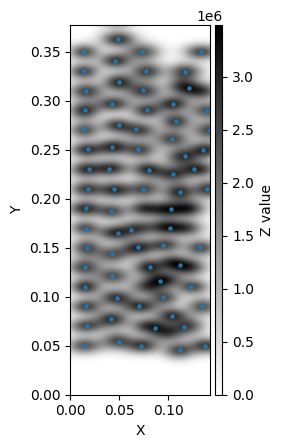

In [19]:
# Find local maxima coordinates
coordinates = peak_local_max(image[2], min_distance=1)

# 2D plot in grayscale - selected image for initial development
fig, ax = plt.subplots()
plot_grayscale(x, y, image[2], ax)
ax.scatter(image[0][0, [coordinates[:, 1]]], image[1][coordinates[:, 0], 0], s=5)

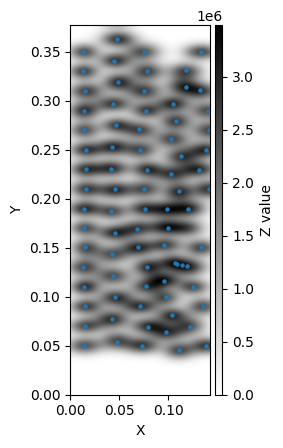

In [20]:
# Find local maxima coordinates
z_laplace = laplace(image[2])
z_laplace[np.nonzero(z_laplace >= 0)] = 0
coordinates = peak_local_max(-1 * z_laplace, min_distance=1)

# 2D plot in grayscale - selected image for initial development
fig, ax = plt.subplots()
plot_grayscale(x, y, image[2], ax)
ax.scatter(image[0][0, [coordinates[:, 1]]], image[1][coordinates[:, 0], 0], s=5)

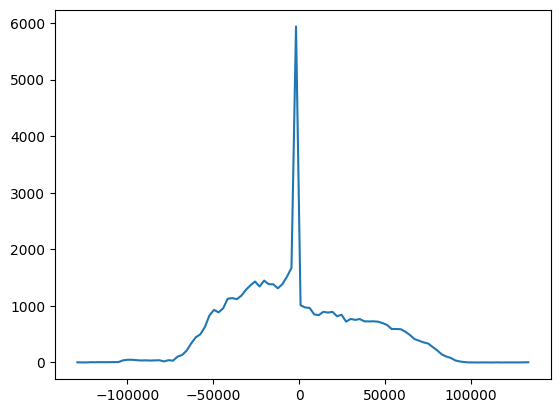

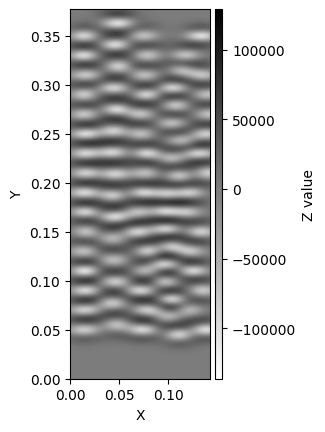

In [21]:
# Thresholding laplacian
# histogram of values
histogram, bin_edges = np.histogram(-1 * laplace(image[2]), bins=100)

fig, ax = plt.subplots()
ax.plot(bin_edges[0:-1], histogram)

fig, ax = plt.subplots()
plot_grayscale(x, y, laplace(image[2]), ax)

estimate_parameters_gmm executed in 3.1152539253234863 seconds
ppl_fit_gaussians executed in 3.955233573913574 seconds


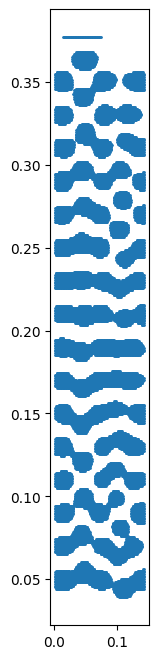

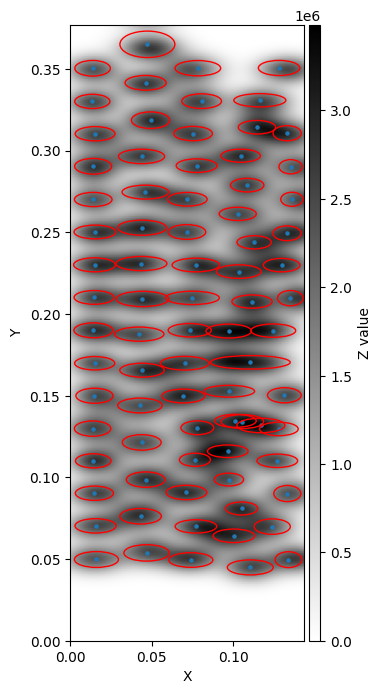

In [22]:
# Estimate Gaussian - Final prediction
(means, covariances, angles, amplitudes) = ppl_fit_gaussians(
    image,
    means_init="laplace",
    peak_method="laplace",
    em_iterations=1000,
    covariance_gaussians_type="diag",
    n_gaussians=None,
    image_ranges=[
        (0, NOTEBOOK_CONFIG["IMG_WIDTH"]),
        (0, NOTEBOOK_CONFIG["IMG_LENGTH"]),
    ],
    image_size=[NOTEBOOK_CONFIG["IMG_XDIM"], NOTEBOOK_CONFIG["IMG_YDIM"]],
    fig_size=(10, 8),
    plot=True,
    plot_points=True,
)

Number of indentifiable Gaussians (center in the image): 79


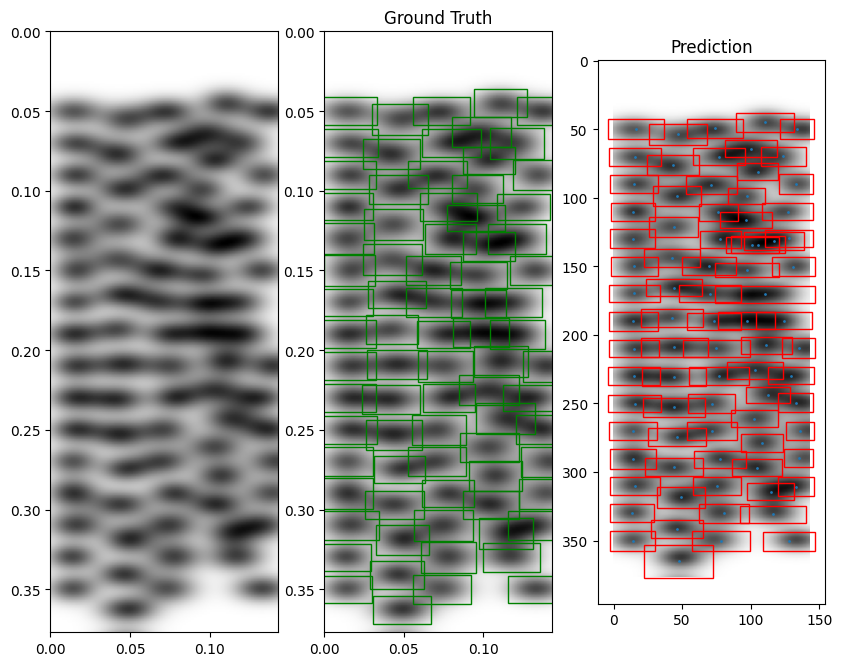

In [ ]:
# Open the image file
im = Image.open(image_path)

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 12))

# Display the image and plot predicted centers
axs[2].imshow(im)
plot_boxes_gmm(means=means, covariances=covariances, ax=axs[2], beta=3, edge_color="g")
axs[2].set_ylim(ax.get_ylim()[::-1])
axs[2].scatter(means[:, 0] * 1000, means[:, 1] * 1000, s=1)
# axs[2].axis('off')
axs[2].set_xlim(0, NOTEBOOK_CONFIG["IMG_XDIM"])
axs[2].set_ylim(0, NOTEBOOK_CONFIG["IMG_YDIM"])

# axs[2].set_title("Prediction")

# Labelling
x, y, z = gaussians_labelled(
    image_path,
    label_path,
    axs[1],
    task=NOTEBOOK_CONFIG["task"],
    colorbar=False,
    plot_centers=True,
)
# axs[1].axis('off')
axs[1].set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])
axs[1].set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])
# axs[1].set_title("Ground Truth")

# Image
plot_grayscale(x, y, z, colorbar=False, ax=axs[0])
# axs[0].axis('off')
axs[0].set_xlim(0, NOTEBOOK_CONFIG["IMG_WIDTH"])
axs[0].set_ylim(0, NOTEBOOK_CONFIG["IMG_LENGTH"])


for ax in axs:
    ax.xaxis.label.set_text("")
    ax.yaxis.label.set_text("")

    ax.set_xticks([])
    ax.set_yticks([])
    # Change the color of the axis spines (borders)
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")
        spine.set_linewidth(1)

plt.subplots_adjust(wspace=0)
plt.show()

### Error evaluation
- Dispersion_x in the mat file is equal to sqrt(2) * sigma_x, same for y direction

In [ ]:
# Get number of images that need to be evaluated - YOLO test set
images_test = os.listdir(
    f"docs/Models/{NOTEBOOK_CONFIG['model_name']}/datasets/test/images/"
)
eval_images = [
    int(i.split("_")[1].split(".")[0]) for i in images_test
]  # Use the same images of the test from YOLO

In [ ]:
print(eval_images)

[156, 74, 6, 60, 166, 128, 88, 65, 177, 176, 37, 116, 39, 188, 110, 98, 62, 93, 178, 149, 364, 386, 345, 367, 398, 385, 348, 399, 308, 290, 205, 340, 295, 269, 395, 246, 292, 352, 354, 254]


In [ ]:
# Iterate all images - GMM method
results = {
    "Image": [],
    "Number identified - gmm": [],
    "Number identifiable - gmm": [],
    "Percentage - gmm": [],
    "RMSE_cx - gmm": [],
    "RMSE_cy - gmm": [],
    "RMSE_c - gmm": [],
    "RMSE_sigmax - gmm": [],
    "RMSE_sigmay - gmm": [],
    "RMSE_sigma - gmm": [],
    "RMSE_amplitude - gmm": [],
    "MaxE_sigmax - gmm": [],
    "MaxE_sigmay - gmm": [],
    "MaxE_sigma - gmm": [],
    "RMSE_amplitude - gmm": [],
    "RMSEPixel - gmm": [],
}

for n_image in eval_images:
    eval_gaussian = ppl_error_estimation(
        n_image,
        mat,
        peak_method="laplace",
        estimation_method="gmm",
        covariance_gaussians_types="diag",
        return_percentage=True,
    )
    # Append values in the dictionary
    for key in results.keys():
        if key in eval_gaussian:
            results[key] += eval_gaussian[key]

estimate_parameters_gmm executed in 0.8780488967895508 seconds
ppl_fit_gaussians executed in 0.9193193912506104 seconds
covariances [[[0.01179383 0.        ]
  [0.         0.00431289]]]
covariances true [[[0.01421697 0.        ]
  [0.         0.00684717]]]
estimate_parameters_gmm executed in 0.910513162612915 seconds
ppl_fit_gaussians executed in 0.9249527454376221 seconds
covariances [[[0.01257954 0.        ]
  [0.         0.00382766]]]
covariances true [[[0.01484551 0.        ]
  [0.         0.00592808]]]
estimate_parameters_gmm executed in 2.162014961242676 seconds
ppl_fit_gaussians executed in 2.1895463466644287 seconds
covariances [[[0.01087035 0.        ]
  [0.         0.00434063]]]
covariances true [[[0.01249584 0.        ]
  [0.         0.00613002]]]
estimate_parameters_gmm executed in 1.6371867656707764 seconds
ppl_fit_gaussians executed in 1.655954360961914 seconds
covariances [[[0.01132571 0.        ]
  [0.         0.00410007]]]
covariances true [[[0.01236114 0.        ]
  [

In [ ]:
pd.DataFrame.from_dict(results).describe().round(2).loc[["mean", "std", "max"]].T

,mean,std,max
Image,218.95,124.81,399.00
Number identified - gmm,71.58,4.71,78.00
Number identifiable - gmm,79.05,0.55,80.00
Percentage - gmm,90.55,5.98,98.73
RMSE_cx - gmm,2.03,0.58,3.45
RMSE_cy - gmm,0.37,0.08,0.64
RMSE_c - gmm,2.07,0.57,3.49
RMSE_sigmax - gmm,20.17,5.31,26.94
RMSE_sigmay - gmm,43.47,4.45,48.95
RMSE_sigma - gmm,48.02,6.17,54.84


In [ ]:
pd.DataFrame.from_dict(results).round(2)

,Image,Number identified - gmm,Number identifiable - gmm,Percentage - gmm,RMSE_cx - gmm,RMSE_cy - gmm,RMSE_c - gmm,RMSE_sigmax - gmm,RMSE_sigmay - gmm,RMSE_sigma - gmm,RMSE_amplitude - gmm,MaxE_sigmax - gmm,MaxE_sigmay - gmm,MaxE_sigma - gmm,RMSEPixel - gmm
0,156,66,80,82.50,1.64,0.42,1.70,14.13,38.45,40.96,18.49,38.23,55.98,67.79,319527.90
1,74,68,80,85.00,1.19,0.27,1.22,13.34,38.93,41.15,19.87,35.23,48.26,59.75,308695.62
2,6,68,79,86.08,1.47,0.28,1.50,16.18,41.52,44.56,15.80,57.94,170.05,179.65,305709.62
3,60,64,79,81.01,1.56,0.50,1.64,17.35,39.00,42.69,22.86,188.49,63.13,198.78,333010.72
4,166,72,80,90.00,1.62,0.38,1.67,14.88,40.36,43.02,12.12,39.64,62.05,73.63,315642.50
5,128,66,80,82.50,1.38,0.37,1.43,14.19,38.82,41.33,22.62,41.08,50.03,64.74,322487.24
6,88,69,79,87.34,1.23,0.39,1.29,15.88,39.87,42.92,17.45,43.29,52.16,67.78,318371.99
7,65,68,80,85.00,1.30,0.32,1.34,14.50,39.85,42.40,18.96,43.12,53.00,68.33,334563.56
8,177,68,78,87.18,2.35,0.31,2.37,15.57,39.05,42.04,19.67,141.65,50.78,150.47,320572.39
9,176,68,79,86.08,1.27,0.35,1.31,17.60,38.72,42.54,18.02,40.34,51.07,65.08,323529.39


In [ ]:
pd.DataFrame.from_dict(results).round(2)

,Image,Number identified - gmm,Number identifiable - gmm,Percentage - gmm,RMSE_cx - gmm,RMSE_cy - gmm,RMSE_c - gmm,RMSE_sigmax - gmm,RMSE_sigmay - gmm,RMSE_sigma - gmm,RMSE_amplitude - gmm,MaxE_sigmax - gmm,MaxE_sigmay - gmm,MaxE_sigma - gmm,RMSEPixel - gmm
0,156,66,80,82.50,1.64,0.42,1.70,14.13,38.45,40.96,18.49,38.23,55.98,67.79,319527.90
1,74,68,80,85.00,1.19,0.27,1.22,13.34,38.93,41.15,19.87,35.23,48.26,59.75,308695.62
2,6,68,79,86.08,1.47,0.28,1.50,16.18,41.52,44.56,15.80,57.94,170.05,179.65,305709.62
3,60,64,79,81.01,1.56,0.50,1.64,17.35,39.00,42.69,22.86,188.49,63.13,198.78,333010.72
4,166,72,80,90.00,1.62,0.38,1.67,14.88,40.36,43.02,12.12,39.64,62.05,73.63,315642.50
5,128,66,80,82.50,1.38,0.37,1.43,14.19,38.82,41.33,22.62,41.08,50.03,64.74,322487.24
6,88,69,79,87.34,1.23,0.39,1.29,15.88,39.87,42.92,17.45,43.29,52.16,67.78,318371.99
7,65,68,80,85.00,1.30,0.32,1.34,14.50,39.85,42.40,18.96,43.12,53.00,68.33,334563.56
8,177,68,78,87.18,2.35,0.31,2.37,15.57,39.05,42.04,19.67,141.65,50.78,150.47,320572.39
9,176,68,79,86.08,1.27,0.35,1.31,17.60,38.72,42.54,18.02,40.34,51.07,65.08,323529.39


In [ ]:
# SNAPSHOTS THE RESULTS WITH THE ANNOTATIONS
snapshot_folder_path = f"""docs/Results/snapshot_v{str(datetime.now().date())}/"""

# Save for Yolo
checkpoint_error(
    snapshot_folder_path=snapshot_folder_path,
    error_dataframe=pd.DataFrame.from_dict(results).sort_values("Image"),
    annotation=f"""Amplitudes estimated using the center directly\n
                 image_path = {images_test}\n
                 id_estimation_method = {"GMM - random state 13 - 200 - 400 images"}\n
                 id_images evaluated: {eval_images}""",
    name="E12GMM",
)

#### Total error

In [ ]:
# Computing error
gaussians = list(zip(means, covariances, amplitudes))

# Generate image from Gaussians and compute MSE
generated_image = sum_gaussians(x, y, gaussians)
mse = compute_mse(image[2], generated_image)